# Tutorial on Using Automated Dependence Plots

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import helpers  # Demo helper functions

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

## Dataset

Load the dataset used for training and testing the model. ```helpers.py``` contains functions that are used for loading certain types of data, so modify this file to load your own data, or simply load the data on this notebook directly. 

Here in this tutorial we will use [German Credit Data in UCI Repository](http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) ). 

Here we need the following information about the data used to train the model. 

* ```dtypes```: Pandas Series object indicating the type of the data value for each features

* ```feature_labels```: 1-D array of strings containing the feature names for each dimension of the data


In [2]:
# Fetch/download data
D = helpers.fetch_german_data()
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# SelectNumeric only
numeric = ~is_categorical(dtypes)
X = X[:, numeric]

feature_labels = feature_labels[numeric]
dtypes = dtypes[numeric]

In [3]:
# Get train test splits
X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('# train', len(y_train))
print('# test', len(y_test))

# train 900
# test 100


In [4]:
dtypes, type(dtypes)

(duration          float64
 amount            float64
 inst_rate         float64
 residing_since    float64
 age               float64
 num_credits       float64
 dependents        float64
 dtype: object,
 pandas.core.series.Series)

In [5]:
feature_labels

array(['duration', 'amount', 'inst_rate', 'residing_since', 'age',
       'num_credits', 'dependents'], dtype=object)

## Train Your Model

Train your model here, or load a pre-trained model here so that the explanation can make use of it. Here, we train a random forest classifier, using a method from ```helper.py``` module. You can define your own model too. 

In [6]:
mm = helpers.create_model('RandomForest', dtypes, random_state=0)
model = mm['estimator']
model.fit(X_train, y_train)

print(accuracy_score(model.predict(X_train), y_train))
print(accuracy_score(model.predict(X_test), y_test))

0.77
0.63


## Model Wrapper

Because our method is a model-agnostic method for black-box classifiers, all information we need from the model is what its output is for a given input. To do this, simply create a model wrapper which takes in input data and outputs the model's prediction value. The internals (e.g. how you implemented your model) do not matter as long as the output value is returned for the given input. The output value for each input has to be a scalar. 

In [7]:
def model_wrapper(X, model=model):
    func = mm['get_model'](mm['estimator'])
    return func(X)

In [8]:
model_wrapper(X_test)

array([ 1.14610215,  0.91336538,  0.40663619,  0.61010093,  1.24777002,
        1.22148368,  1.76599849,  1.61604803,  1.16966155,  1.53767172,
        1.23748284,  1.50612591,  0.66294265,  0.91846688,  0.80681493,
        1.06351375,  1.11851639,  0.59341603,  0.30959386,  1.08636112,
        0.2925898 ,  0.94609443, -0.15118728,  1.14678723,  1.2025753 ,
        1.26910712,  0.53809867,  0.17697172,  0.80515122,  1.41579225,
        1.05923926,  0.88437299,  0.77335172,  1.1319298 ,  1.20815987,
        1.64720814,  0.92917746,  1.29280406,  0.50355338,  1.11522329,
        2.51028317,  1.14279395, -0.1507316 ,  0.45080385,  0.16983558,
        1.6085242 ,  0.52356182, -0.39464671,  1.11968349,  1.10805518,
        1.07218617,  0.91597301,  1.41280882,  1.1817498 , -0.71103986,
        0.6180506 ,  0.88049207,  2.15555311,  0.98610913,  1.08506922,
        0.88583058,  0.87322504,  1.2407276 , -0.53090128,  0.9573365 ,
        0.86534598, -0.90035015,  0.71314707,  0.99297718,  1.64

## Utility Functions   

Define a utility function to use for the explanation. This depends on what type of behavior you are expecting along the direction the explanation is optimizing for. Examples of the utility functions can be found in ```adp/utility.py```. Here we list some of them and describe what they do.

* ```ModelContrastUtility```: measures the deviance from another model's output values

* ```LeastConstantUtility```: measures the deviance the original prediction value of the target point

* ```LeastMonotonicUtility```: measures how monotonic the function values are (larger means less monotonic)

### Two ways to compute utility values
1. Directly call the class method ```from_plot_vals(x, y, ...)```.  This enables the utilities to be used with other frameworks or plot types.
2. Define the utility function to use by initializing the class with the model wrapper as an argument.  The utility can then be called directly, i.e., ```utility(curve)```, where ```curve``` is a curve object (see ```adp.curve```). This will be used in the optimize function below.


In [9]:
# Directly calling class method to compute utility
x_vals = np.linspace(0, 2*np.pi)
y_vals = np.sin(x_vals)
out = LeastMonotonicUtility.from_plot_vals(x_vals, y_vals)
print('Utility = %g' % out)

Utility = 0.0704853


In [10]:
# Setup a utility instance for use in optimization
utility = LeastMonotonicUtility(model_wrapper)

## Target Point 

Set a target point, or a data point that you want the explanation for.

In [11]:
x0 = X_test[0]
print(x0)

[1.200e+01 2.969e+03 4.000e+00 3.000e+00 2.500e+01 2.000e+00 1.000e+00]


## Optimization and Plotting

Now we want to find the direction of the curve that optimizes (maximizes) the utility function defined above, starting from the target point specified. The direction can be univariate (coodinatewise) and multivariate, and this option is controlled by the argument ```max_numeric_change``` in the function ```optimize_curve```. After you optimize, the curve object is returned, and you can plot the curve using the function ```plot_curve_vals```. 

### Univariate Direction

For the univariate direction, we set ```max_numeric_change=1``` for the argument. Note all other arguments that is required for optimizing and plotting. 

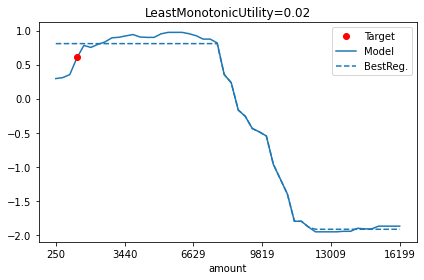

In [12]:
best_curve = optimize_curve(X_test[3], utility, X, max_numeric_change=1, dtypes=dtypes)
plot_curve_vals(best_curve, utility=utility, feature_labels=feature_labels)

What the we find from above is that given a target point in red, the univariate direction that maximizes the ```LeastMonotonicUtility``` is ```amount``` of the loan (shown in x-axis label). In other words, changing ```amount``` feature values of the given target point results in the model's output value to change least monotonically. As the amount of the loan increases, the score of the predicted acceptance (y-axis) goes down according to the model. 

### Multivariate Directions

For multivariate directions, we set ```max_numeric_change``` as the number of variables you want to consider changing at the same time. 

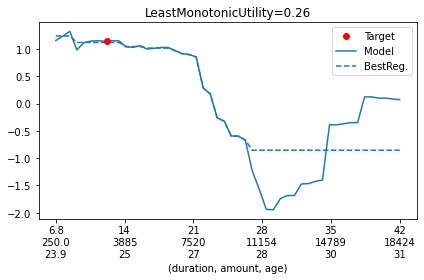

In [13]:
best_curve = optimize_curve(x0, utility, X, max_numeric_change=3, dtypes=dtypes)
plot_curve_vals(best_curve, utility=utility, feature_labels=feature_labels)

This time we are interested in changing three feature values at the same time, and we find that the least monotonic direction is obtained with changing ```duration``` of the loan, ```amount``` of the loan, and the number of years the person has been ```residing_since```. The values for each of these features are written in order along the x-axis. 